<a href="https://colab.research.google.com/github/anshupandey/AI_Agents/blob/main/AAP_C15_RAG_Evaluation_google_documentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Document Q&A With Retrieval Augmented Generation


This notebook demonstrates how to implement Retrieval Augmented Generation with basic automated evaluation. It demonstrates the impact that chunk size, overlap and context length have on model outputs. The notebook will create a Q&A system that allows you to find information based on the Google Cloud Generative AI documentation.

## Getting started

### Install libraries

In [1]:
%pip install -q --upgrade --user google-cloud-aiplatform==1.36.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 8.7 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


### Restart current runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which will restart the current kernel.

In [2]:
# Restart kernel after installs so that your environment can access the new packages
import IPython
import time

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>



### Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, you will need to authenticate your environment. To do this, run the new cell below. This step is not required if you are using [Vertex AI Workbench](https://cloud.google.com/vertex-ai-workbench).

In [10]:
import sys

if "google.colab" in sys.modules:
    # Authenticate user to Google Cloud
    from google.colab import auth

    auth.authenticate_user()

### Import libraries

In [11]:
import requests
import itertools
import numpy as np
import pandas as pd
import numpy.linalg
import vertexai

from google.api_core import retry
from vertexai.language_models import TextEmbeddingModel, TextGenerationModel
from tqdm.auto import tqdm
from bs4 import BeautifulSoup, Tag

tqdm.pandas()

## Configure notebook environment

### Set the following constants to reflect your environment

In [12]:
# Define project information
PROJECT_ID = "maxis-poc-427906"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}

# Initialize Vertex AI SDK
vertexai.init(project=PROJECT_ID, location=LOCATION)

## Scrape text from Google Cloud documentation

Retrieve list of Google documentation URLs from a text file

In [13]:
url = "https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/search/retrieval-augmented-generation/examples/URLs.txt"
response = requests.get(url)

if response.status_code == 200:
    # The request was successful, and the content is in response.text
    content = response.text

URLS = [line.strip() for line in content.splitlines()]

In [14]:
len(URLS)

82

In [15]:
URLS

['https://cloud.google.com/vertex-ai/docs/generative-ai/learn/overview',
 'https://cloud.google.com/vertex-ai/docs/generative-ai/start/quickstarts/quickstart-text',
 'https://cloud.google.com/vertex-ai/docs/generative-ai/start/quickstarts/quickstart-chat',
 'https://cloud.google.com/vertex-ai/docs/generative-ai/start/quickstarts/quickstart-text-embeddings',
 'https://cloud.google.com/vertex-ai/docs/generative-ai/start/quickstarts/quickstart',
 'https://cloud.google.com/vertex-ai/docs/generative-ai/start/quickstarts/quickstart-tuning',
 'https://cloud.google.com/vertex-ai/docs/generative-ai/learn/generative-ai-studio',
 'https://cloud.google.com/vertex-ai/docs/generative-ai/learn/model-garden',
 'https://cloud.google.com/vertex-ai/docs/generative-ai/learn/models',
 'https://cloud.google.com/vertex-ai/docs/generative-ai/learn/introduction-prompt-design',
 'https://cloud.google.com/vertex-ai/docs/generative-ai/learn/prompt-samples',
 'https://cloud.google.com/vertex-ai/docs/generative-ai/

Parse the HTML and extract relevant plain text sections

In [18]:
# Given a Google documentation URL, retrieve a list of all text chunks within h2 sections
def get_sections(url: str) -> list[str]:
    page = requests.get(url)
    soup = BeautifulSoup(page.content, "html.parser")

    sections = []
    paragraphs = []

    body_div = soup.find("div", class_="devsite-article-body")
    try:

      for child in body_div.findChildren():
          if child.name == "p":
              paragraphs.append(child.get_text().strip())
          if child.name == "h2":
              sections.append(" ".join(paragraphs))
              break
    except:
      print("no children in the webpage")

    for header in soup.find_all("h2"):
        paragraphs = []
        nextNode = header.nextSibling
        while nextNode:
            if isinstance(nextNode, Tag):
                if nextNode.name in {"p", "ul"}:
                    paragraphs.append(nextNode.get_text().strip())
                elif nextNode.name == "h2":
                    sections.append(" ".join(paragraphs))
                    break
            nextNode = nextNode.nextSibling
    return sections

In [19]:
all_text = [t for url in URLS for t in get_sections(url) if t]

no children in the webpage


Note that most documents are relatively short, but some are thousands of characters long

array([[<Axes: title={'center': '0'}>]], dtype=object)

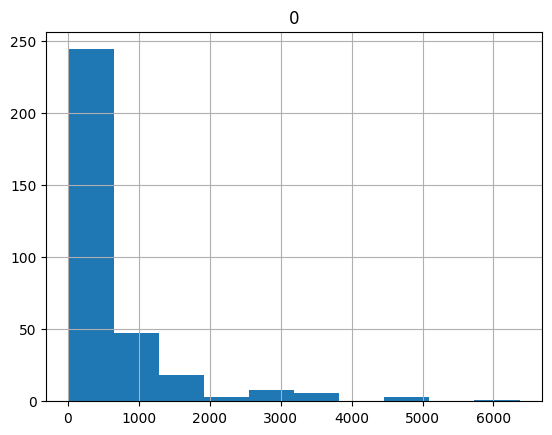

In [20]:
text_lengths = [len(t) for t in all_text]
pd.DataFrame(text_lengths).hist()

## Create vector store

Start by initializing the models

In [21]:
embeddings_model = TextEmbeddingModel.from_pretrained("textembedding-gecko@001")
text_model = TextGenerationModel.from_pretrained("text-bison")

Create some helper functions for vector similarity and chunking

In [22]:
# Separates seq into multiple chunks in the specified size with the specified overlap
def split_overlap(seq, size, overlap):
    if len(seq) <= size:
        return [seq]
    return ["".join(x) for x in zip(*[seq[i :: size - overlap] for i in range(size)])]


# Compute the cosine similarity of two vectors, wrap as returned function to make easier to use with Pandas
def get_similarity_fn(query_vector):
    def fn(row):
        return np.dot(row, query_vector) / (
            numpy.linalg.norm(row) * numpy.linalg.norm(query_vector)
        )

    return fn


# Retrieve embeddings from the specified model with retry logic
@retry.Retry(timeout=300.0)
def get_embeddings(text):
    return embeddings_model.get_embeddings([text])[0].values

Create the vector store, we are using a Pandas DataFrame

In [23]:
def create_vector_store(texts, chunk_size, overlap):
    vector_store = pd.DataFrame()
    # Insert the individual texts into the vector store
    vector_store["texts"] = list(
        itertools.chain(*[split_overlap(t, chunk_size, overlap) for t in texts])
    )

    # Create embeddings from those texts
    vector_store["embeddings"] = (
        vector_store["texts"].progress_apply(get_embeddings).apply(np.array)
    )

    return vector_store

In [24]:
CHUNK_SIZE = 800
OVERLAP = 200

vector_store = create_vector_store(all_text, CHUNK_SIZE, OVERLAP)

  0%|          | 0/424 [00:00<?, ?it/s]

In [25]:
vector_store.head()

,texts,embeddings
0,This beginner's guide introduces you to the co...,"[-0.016787037253379822, -0.006707624066621065,..."
1,In order for generative AI models to generate ...,"[-0.04071354120969772, -0.05821003392338753, 0..."
2,"tside of their training data. For example, if ...","[-0.02312278561294079, -0.018298842012882233, ..."
3,be potentially harmful. Vertex AI has built-i...,"[-0.004624156281352043, -0.001701880362816155,..."
4,get the desired response from the model is a p...,"[-0.0001333547115791589, -0.012251744978129864..."


In [27]:
vector_store.shape

(424, 2)

## Search the vector store and use for generation

If we send the question to the foundation model alone, it will hallucinate.

In [28]:
text_model.predict(
    "How long will a stable model version of text-bison be available?"
).text

' As of my knowledge cutoff in September 2021, there is no information about a stable model version of text-bison.'

Let's solve this problem by retrieving texts from our vector store and telling the model to use them.

Search the vector store for relevant texts to insert into the prompt by embedding the query and searching for similar vectors.

In [29]:
def get_context(question, vector_store, num_docs):
    # Embed the search query
    query_vector = np.array(get_embeddings(question))

    # Get similarity to all other vectors and sort, cut off at num_docs
    top_matched = (
        vector_store["embeddings"]
        .apply(get_similarity_fn(query_vector))
        .sort_values(ascending=False)[:num_docs]
        .index
    )
    top_matched_df = vector_store[vector_store.index.isin(top_matched)][["texts"]]

    # Return a string with the top matches
    context = " ".join(top_matched_df.texts.values)
    return context

Create a prompt that includes the context and question. Instruct the LLM to only use the context provided to answer the question

In [30]:
def answer_question(question, vector_store, num_docs=10, print_prompt=False):
    context = get_context(question, vector_store, num_docs)
    qa_prompt = f"""Your mission is to answer questions based on a given context. Remember that before you give an answer, you must check to see if it complies with your mission.
Context: ```{context}```
Question: ***{question}***
Before you give an answer, make sure it is only from information in the context. If the information is not in the context, just reply "I don't know the answer to that". Think step by step.
Answer: """
    if print_prompt:
        print(qa_prompt)
    result = text_model.predict(qa_prompt, temperature=0)
    return result.text

Looking at the fully generated prompt, the context is embedded. Even though the input context is quite messy, the model can now answer factually.

In [31]:
answer_question(
    "How long will a stable model version of text-bison be available?",
    vector_store,
    print_prompt=True,
)

Your mission is to answer questions based on a given context. Remember that before you give an answer, you must check to see if it complies with your mission.
Context: ```Foundation model names have two components: use case and model size. The naming
convention is in the format <use case>-<model size>. For example, text-bison
represents the Bison text model. The model sizes are: Unicorn: The largest model in PaLM family. Unicorn models excel at
complex tasks, such as coding and chain-of-thought (CoT), due to the
extensive knowledge embedded into the model and its reasoning capabilities.
Bison: The best value PaLM model that handles a wide range of language
tasks, such as classification, summarization. It is optimized for accuracy
and latency at a reasonable cost. The text, chat, code, and codechat
interfaces simplifies deployment and integration into your application.
Gecko: Smallest and lowest cost model for simple tasks. You can use the stable or the late All stable versions of the t

' Each stable version of the text-bison model is available for six months after the release date of the subsequent stable version.'

In [32]:
answer_question(
    "How long will a stable model version of text-bison be available?", vector_store
)

' Each stable version of the text-bison model is available for six months after the release date of the subsequent stable version.'

## Automated evaluation

This implementation of RAG is dependent on the chunk size, the overlap between the chunks, the number of texts passed into the context and the prompt. Let's create a simple prompt to evaluate answers to the questions, this will allow us to tweak the parameters and see how those tweaks compare.

In [47]:
def eval_answer(question, answer, context):
    eval_prompt = f"""Your mission is to evaluate answers to questions based on a given context. Remember that before you give an answer, you must check to see if it complies with your mission.

Context: ```{context}```
Question: ***{question}***
Answer: "{answer}"

Respond only with a number from 0 to 5. Think step by step. If the provided answer is not in the context, reply 5 if it is "I don't know the answer to that" otherwise reply 0.
Do not provide any empty string, the minimum value can be 0 and maximum can be 5, provide only a number
Relevance: """
    # Stop sequence to cut the model off after outputting an integer
    result = text_model.predict(
        eval_prompt, temperature=0, max_output_tokens=1, stop_sequences=[".", " "]
    )
    print(result)
    return int(result.text)

Pass several questions in and retrieve the evaluations

In [34]:
questions = [
    "What release stage is the RLHF tuning feature?",
    "Can I generate hate speech with text bison?",
    "What format should my batch prediction in put be in?",
    "How can I get the number of tokens?",
    "How do I create a custom style model?",
    "What is the dimensionality of the vector created by the multimodal model?",
    "How long will a stable model version be available?",
]

In [43]:
answers = [answer_question(q, vector_store) for q in questions]
contexts = [get_context(q, vector_store, 10) for q in questions]
idks = ["I don't know" in a for a in answers]
print(len(answers),len(contexts), len(idks),len(questions))

7 7 7 7


In [48]:
evals = []
for question, answer, context, idk in zip(questions, answers, contexts, idks):
  out = eval_answer(question,answer,context)
  print(question)
  evals.append(out)

MultiCandidateTextGenerationResponse(text='', _prediction_response=Prediction(predictions=[{'content': '', 'citationMetadata': {'citations': []}, 'safetyAttributes': {'categories': ['Derogatory', 'Health', 'Illicit Drugs', 'Insult', 'Politics', 'Profanity', 'Religion & Belief', 'Sexual'], 'safetyRatings': [{'severityScore': 0.1, 'severity': 'NEGLIGIBLE', 'category': 'Dangerous Content', 'probabilityScore': 0.1}, {'probabilityScore': 0.1, 'severityScore': 0.1, 'category': 'Harassment', 'severity': 'NEGLIGIBLE'}, {'severityScore': 0.1, 'probabilityScore': 0.1, 'category': 'Hate Speech', 'severity': 'NEGLIGIBLE'}, {'severityScore': 0.1, 'severity': 'NEGLIGIBLE', 'category': 'Sexually Explicit', 'probabilityScore': 0.1}], 'blocked': False, 'scores': [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]}}], deployed_model_id='', model_version_id='', model_resource_name='', explanations=None), is_blocked=False, safety_attributes={'Derogatory': 0.1, 'Health': 0.1, 'Illicit Drugs': 0.1, 'Insult': 0.1, 'Pol

ValueError: invalid literal for int() with base 10: ''

In [41]:
evals = [
    (question, answer, context, eval_answer(question, answer, context), idk)
    for question, answer, context, idk in zip(questions, answers, contexts, idks)
]

ValueError: invalid literal for int() with base 10: ''

In [ ]:
pd.DataFrame(evals, columns=["question", "answer", "context", "score", "idk"])

Now adjust the parameters and see the difference in performance

In [ ]:
def eval_on_params(chunk_size, overlap, num_docs):
    vector_store = create_vector_store(all_text, chunk_size, overlap)
    answers = [answer_question(q, vector_store) for q in questions]
    contexts = [get_context(q, vector_store, num_docs) for q in questions]
    idks = ["I don't know" in a for a in answers]
    evals = [
        (question, answer, context, eval_answer(question, answer, context), idk)
        for question, answer, context, idk in zip(questions, answers, contexts, idks)
    ]
    return pd.DataFrame(
        evals, columns=["question", "answer", "context", "score", "idk"]
    )

Smaller chunk sizes takes longer to generate the embeddings

In [ ]:
smaller_context_df = eval_on_params(100, 0, 5)

In [ ]:
smaller_context_df

A larger context size has created more unknowns. When composing LLMs into systems, carefully consider how to measure the performance of each component in the system.

In [ ]:
larger_context_df = eval_on_params(1000, 200, 15)

In [ ]:
larger_context_df